In [1]:
import os
import flopy as fp
import flopy.utils as fu
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

### load in the voronoi version of the class project model

In [2]:
modelpath = Path('data/voronoi/')

In [3]:
base_sim = fp.mf6.MFSimulation.load(sim_ws=str(modelpath))

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...


In [4]:
base_m = base_sim.get_model()

### let's make sure we can read in the SFR observations data which we will need for calculating depletion

In [5]:
sfr_base_obs = pd.read_csv(modelpath / 'sfr_obs.csv', index_col=0)

In [6]:
sfr_base_obs = sfr_base_obs[['GAGE1','GAGE2']]

In [7]:
sfr_base_obs

,GAGE1,GAGE2
time,,
1.0,-858469.278905,-867288.493036


## find all the locations of cells

In [8]:
cells = pd.DataFrame.from_records(base_m.dis.cell2d.array)
cells

,icell2d,xc,yc,ncvert,icvert_0,icvert_1,icvert_2,icvert_3,icvert_4,icvert_5,icvert_6,icvert_7,icvert_8,icvert_9
0,0,5000.000000,8000.000000,6,197,4806,4670,4807,4668,411,None,None,None,None
1,1,5000.000000,7750.000000,7,412,411,4668,4669,4850,4848,410,None,None,None
2,2,5000.000000,7500.000000,7,410,4848,4736,4849,4734,195,196,None,None,None
3,3,5000.000000,7250.000000,7,415,195,4734,4735,4787,4785,414,None,None,None
4,4,5000.000000,7000.000000,7,414,4785,4721,4786,4719,199,416,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2235,1845.728694,831.396208,7,124,45,44,77,79,46,125,None,None,None
2236,2236,1939.697138,8644.069796,6,500,501,505,504,503,502,None,None,None,None
2237,2237,2224.617777,8931.235118,6,501,785,783,490,254,505,None,None,None,None
2238,2238,1491.310956,8710.546962,6,98,22,500,502,263,262,None,None,None,None


# find the locations of cells that  contain streams and let's not place wells in or under them 

In [9]:
sfrcells = pd.DataFrame.from_records(base_m.sfr.packagedata.array)
sfrcells

,rno,cellid,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,boundname
0,0,"(2, 367)",50.649038,5.010196,0.000161,16.495922,0.502039,3.5,0.035,1,1.0,0,upstream
1,1,"(2, 368)",94.011396,5.039316,0.000161,16.484274,0.507863,3.5,0.035,2,1.0,0,upstream
2,2,"(2, 369)",116.984410,5.081789,0.000161,16.467284,0.516358,3.5,0.035,2,1.0,0,upstream
3,3,"(2, 370)",130.346654,5.131577,0.000161,16.447369,0.526315,3.5,0.035,2,1.0,0,upstream
4,4,"(2, 371)",121.584053,5.182290,0.000161,16.427084,0.536458,3.5,0.035,2,1.0,0,upstream
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,"(2, 1763)",98.589885,9.907079,0.000161,14.537168,1.481416,3.5,0.035,2,1.0,0,downstream
164,164,"(2, 1773)",69.061267,9.940827,0.000161,14.523669,1.488165,3.5,0.035,2,1.0,0,downstream
165,165,"(2, 1838)",94.392032,9.973731,0.000161,14.510508,1.494746,3.5,0.035,2,1.0,0,downstream
166,166,"(2, 1882)",9.370425,9.994618,0.000161,14.502153,1.498924,3.5,0.035,2,1.0,0,downstream


In [10]:
# make a new columns with just the cellid regardless of layer
sfrcells['cell_no_layer'] = [i[1] for i in sfrcells.cellid]
sfrcells

,rno,cellid,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,boundname,cell_no_layer
0,0,"(2, 367)",50.649038,5.010196,0.000161,16.495922,0.502039,3.5,0.035,1,1.0,0,upstream,367
1,1,"(2, 368)",94.011396,5.039316,0.000161,16.484274,0.507863,3.5,0.035,2,1.0,0,upstream,368
2,2,"(2, 369)",116.984410,5.081789,0.000161,16.467284,0.516358,3.5,0.035,2,1.0,0,upstream,369
3,3,"(2, 370)",130.346654,5.131577,0.000161,16.447369,0.526315,3.5,0.035,2,1.0,0,upstream,370
4,4,"(2, 371)",121.584053,5.182290,0.000161,16.427084,0.536458,3.5,0.035,2,1.0,0,upstream,371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,"(2, 1763)",98.589885,9.907079,0.000161,14.537168,1.481416,3.5,0.035,2,1.0,0,downstream,1763
164,164,"(2, 1773)",69.061267,9.940827,0.000161,14.523669,1.488165,3.5,0.035,2,1.0,0,downstream,1773
165,165,"(2, 1838)",94.392032,9.973731,0.000161,14.510508,1.494746,3.5,0.035,2,1.0,0,downstream,1838
166,166,"(2, 1882)",9.370425,9.994618,0.000161,14.502153,1.498924,3.5,0.035,2,1.0,0,downstream,1882


## now we can find the cells from disv that are _not_ also in SFR using a `set` operation

In [11]:
len(set(cells.icell2d)), len(set(sfrcells.cell_no_layer)),

(2240, 168)

In [12]:
len(set(cells.icell2d))-len(set(sfrcells.cell_no_layer))

2072

In [13]:
cells_for_wells = list(set(cells.icell2d)-set(sfrcells.cell_no_layer))
len(cells_for_wells)

2072

### now lets load the well file to find a representative pumping rate

In [14]:
wells = pd.DataFrame.from_records(base_m.wel.stress_period_data.array[0])
wells

,cellid,q
0,"(2, 1315)",-708.480
1,"(2, 1421)",-354.240
2,"(2, 1435)",-336.960
3,"(2, 1286)",-71.712
4,"(2, 1420)",-62.208
5,"(2, 1434)",-371.520


In [15]:
newq = wells.q.mean()
newq

-317.52000000000004

## now let's see about adding a new well - we will reload the model and reset the path to be sure and not stomp on the original model

In [16]:
sim = fp.mf6.MFSimulation.load(sim_ws=str(modelpath))

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...


In [17]:
testmod = sim.get_model()

In [18]:
wells.dtypes

cellid     object
q         float64
dtype: object

### now we can add a new well with the average Q in layer 0, cell 0

In [19]:
twell = fp.mf6.ModflowGwfwel(testmod, save_flows=True, stress_period_data=[[(0,0), newq]])

In [20]:
runpath = Path('temp/depletion/')
sim.set_sim_path(str(runpath))

In [21]:
sim.exe_name='mf6'
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data


In [22]:
sim.run_simulation()

FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.

(True, [])

### now read in the SFR observations and compare with the base run

In [23]:
sfr_test1 = pd.DataFrame.from_records(testmod.sfr.output.obs().get_data())

In [24]:
sfr_test1

,totim,UPSTREAM,DOWNSTREAM,GAGE1,GAGE2
0,1.0,5769.284514,-8741.661096,-858230.715486,-866972.376582


In [25]:
sfr_test = pd.read_csv(runpath / 'sfr_obs.csv')[['GAGE1','GAGE2']]

In [26]:
sfr_test

,GAGE1,GAGE2
0,-858230.715486,-866972.376582


In [27]:
sfr_base_obs

,GAGE1,GAGE2
time,,
1.0,-858469.278905,-867288.493036


In [28]:
(sfr_base_obs.GAGE2.values-sfr_test.GAGE2.values)

array([-316.11645402])

# Cool! We can see a difference in flow pretty close to the new pumping rate. Now we are ready to systematically work with the entire model!

## now let's make a dataframe to hold the depletion calculation results

In [29]:
cellids = np.hstack((cells.icell2d.values, cells.icell2d.values, cells.icell2d.values)) # three layers
layers = np.hstack(([0 for i in range(len(cells.icell2d.values))],
                   [1 for i in range(len(cells.icell2d.values))],
                   [2 for i in range(len(cells.icell2d.values))]))

In [30]:
cells_with_layers = list(zip(layers,cellids))

In [31]:
depletion_results = pd.DataFrame(index=pd.MultiIndex.from_tuples(cells_with_layers), data = {'Gage1':np.nan, 'Gage2':np.nan})
depletion_results

Gage1  Gage2
0 0       NaN    NaN
  1       NaN    NaN
  2       NaN    NaN
  3       NaN    NaN
  4       NaN    NaN
...       ...    ...
2 2235    NaN    NaN
  2236    NaN    NaN
  2237    NaN    NaN
  2238    NaN    NaN
  2239    NaN    NaN

[6720 rows x 2 columns]

# now make a function to run ... the slow way

## we know how to read in the model with flopy, make a change, run it, etc. all using flopy

In [32]:
def run_a_well_flopy(layer, cellid, newq, sfr_base_obs, depletion_results):
    # read in the simulation
    sim = fp.mf6.MFSimulation.load(sim_ws=str(modelpath))
    # get the model
    testmod = sim.get_model()
    # add the test well 
    well_cellid = (layer,cellid)
    twell = fp.mf6.ModflowGwfwel(testmod, save_flows=True, stress_period_data=[[well_cellid, newq]])
    runpath = Path('temp/depletion/')
    sim.set_sim_path(str(runpath))
    sim.exe_name='mf6'
    sim.write_simulation()
    sim.run_simulation()
    sfr_test = pd.read_csv(runpath / 'sfr_obs.csv')[['GAGE1','GAGE2']]
    depletion_results.loc[well_cellid, 'Gage1'] = (sfr_base_obs.GAGE1.values-sfr_test.GAGE1.values)/newq
    depletion_results.loc[well_cellid, 'Gage2'] = (sfr_base_obs.GAGE2.values-sfr_test.GAGE2.values)/newq
    

In [33]:
%%timeit -r 5 # the timeit special function will run the folling code a few times and indicate how long 
              # the mean runtime and variance are
for clay in range(3):
    for cellid in cells_for_wells[:5]:
        run_a_well_flopy(clay, cellid, newq,sfr_base_obs, depletion_results)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:03
 Elapsed run time:  0.242 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:09
 Elapsed run time:  0.229 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:15
 Elapsed run time:  0.226 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:21
 Elapsed run time:  0.227 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:27
 Elapsed run time:  0.218 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:33
 Elapsed run time:  0.227 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:39
 Elapsed run time:  0.231 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:46
 Elapsed run time:  0.220 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:52
 Elapsed run time:  0.231 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:36:58
 Elapsed run time:  0.230 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:37:04
 Elapsed run time:  0.227 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/10/27  9:37:11
 Elapsed run time:  0.228 Seconds
 
 Normal termination of simulation.
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel'

    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: /Users/mnfienen/Documents/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/08/2022

   MODFLOW 6 compiled Mar 10 2022 13:40:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right t

# now make a function to run ... the FAST way
### we will use flopy only to make the initial model and then manipulate and run only with MF6 files directly

### make a test directory to run in

In [34]:
sim = fp.mf6.MFSimulation.load(sim_ws=str(modelpath))
# get the model
testmod = sim.get_model()
# add the test well 
twell = fp.mf6.ModflowGwfwel(testmod, save_flows=True, stress_period_data=[[(0,0), newq]])
runpath = Path('temp/depletion/')
sim.set_sim_path(str(runpath))
sim.exe_name='mf6'
sim.write_simulation()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package sfr...
    loading package wel...
    loading package chd...
    loading package oc...
  loading ims package project...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package project...
  writing model project...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package sfr_obs...
    writing package sfr_0...
    writing package wel_0...
    writing package chd_0...
    writing package oc...
    writing package wel_1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data


### navigate the wel file to see where to put the new cell ids 

In [35]:
inwell = open(runpath / 'project_0.wel', 'r').readlines()
inwell

['# File generated by Flopy version 3.3.6 on 10/27/2022 at 09:37:17.\n',
 'BEGIN options\n',
 '  SAVE_FLOWS\n',
 'END options\n',
 '\n',
 'BEGIN dimensions\n',
 '  MAXBOUND  1\n',
 'END dimensions\n',
 '\n',
 'BEGIN period  1\n',
 '  1 1    -317.52000000\n',
 'END period  1\n',
 '\n']

In [36]:
well_template = []
for line in inwell:
    if str(int(newq)) not in line: # we can just look for our new flowrate
        well_template.append(line)
    else:
        well_template.append('<replace_me>\n')

In [37]:
well_template = ' '.join(well_template)

In [38]:
well_template.replace('<replace_me>',f'1 1 {newq:0.4f}')

'# File generated by Flopy version 3.3.6 on 10/27/2022 at 09:37:17.\n BEGIN options\n   SAVE_FLOWS\n END options\n \n BEGIN dimensions\n   MAXBOUND  1\n END dimensions\n \n BEGIN period  1\n 1 1 -317.5200\n END period  1\n \n'

### now we can run these by just rewriting the wel file directly and suppressing output - should be faster

In [39]:
# set the current working directory so that we can change as needed to run MF6
cwd = os.getcwd()

In [40]:
def run_a_well_just_mf6(layer, cellid, newq, sfr_base_obs, depletion_results_fast):
    print(f'running layer = {layer}, cellid = {cellid}\r', end='')
    with open(runpath / 'project_0.wel','w') as ofp:
        ofp.write(well_template.replace('<replace_me>',f'{layer+1:d} {cellid+1:d} {newq:0.4f}'))
    well_cellid = (layer, cellid)
    os.chdir(runpath)
    os.system('mf6 > nul')
    os.chdir(cwd)
    sfr_test = pd.read_csv(runpath / 'sfr_obs.csv')[['GAGE1','GAGE2']]
    depletion_results_fast.loc[well_cellid, 'Gage1'] = (sfr_base_obs.GAGE1.values-sfr_test.GAGE1.values)/newq
    depletion_results_fast.loc[well_cellid, 'Gage2'] = (sfr_base_obs.GAGE2.values-sfr_test.GAGE2.values)/newq

In [41]:
depletion_results_fast = pd.DataFrame(index=pd.MultiIndex.from_tuples(cells_with_layers), 
                                      data = {'Gage1':np.nan, 'Gage2':np.nan})

In [42]:
%%timeit -r 5
for lay in range(3):
    for cid in cells_for_wells[:5]:
        run_a_well_just_mf6(lay, cid, newq, sfr_base_obs, depletion_results_fast)

3.86 s ± 61.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [43]:
freshrun = False
if freshrun:
    depletion_results_fast.to_csv('data/depletion_results/depletion_results.csv')

In [44]:
drf = pd.read_csv('data/depletion_results/depletion_results.csv', index_col=[0,1])

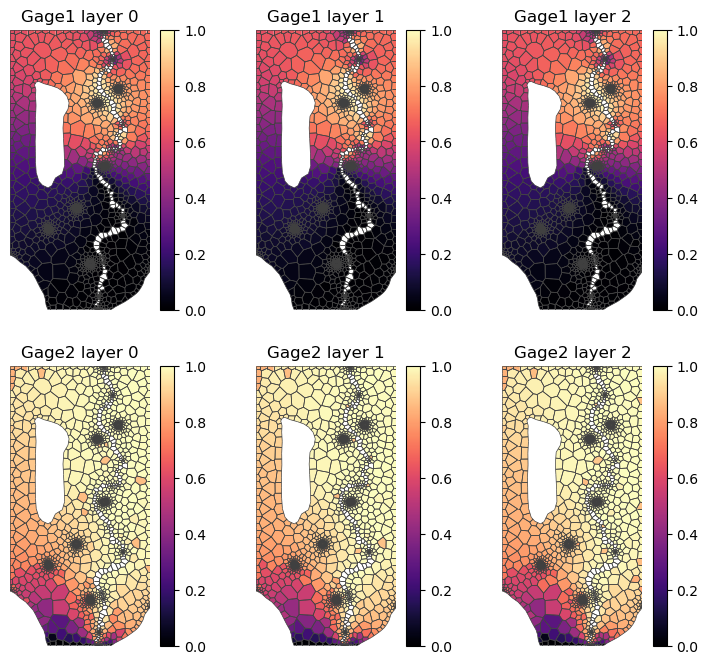

In [45]:
fig, ax = plt.subplots(2,3, figsize=(9,8))
ax = ax.ravel()
ax_num = 0
for gage_num in range(2):
    for lay_num in range(3):
        cax = ax[ax_num]
        data = drf.loc[lay_num][f'Gage{gage_num+1}'].values
        data[data<0] =0
        mm = fp.plot.PlotMapView(model= base_m)
        cb = mm.plot_array(data, vmin=0, vmax=1.0, ax=cax, cmap='magma')
        mm.plot_grid(lw=0.5, color="0.25",ax=cax)
        cax.set_aspect('equal')
        cax.set_title(f'Gage{gage_num+1} layer {lay_num}')
        plt.colorbar(cb, ax=cax)
        cax.axis('off')
        ax_num += 1